In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

Shape of training input tensor: (49479, 7)
Shape of validation input tensor: (21206, 7)
Train class distribution: [12741 22464 14274]
Validation class distribution: [5485 9563 6158]


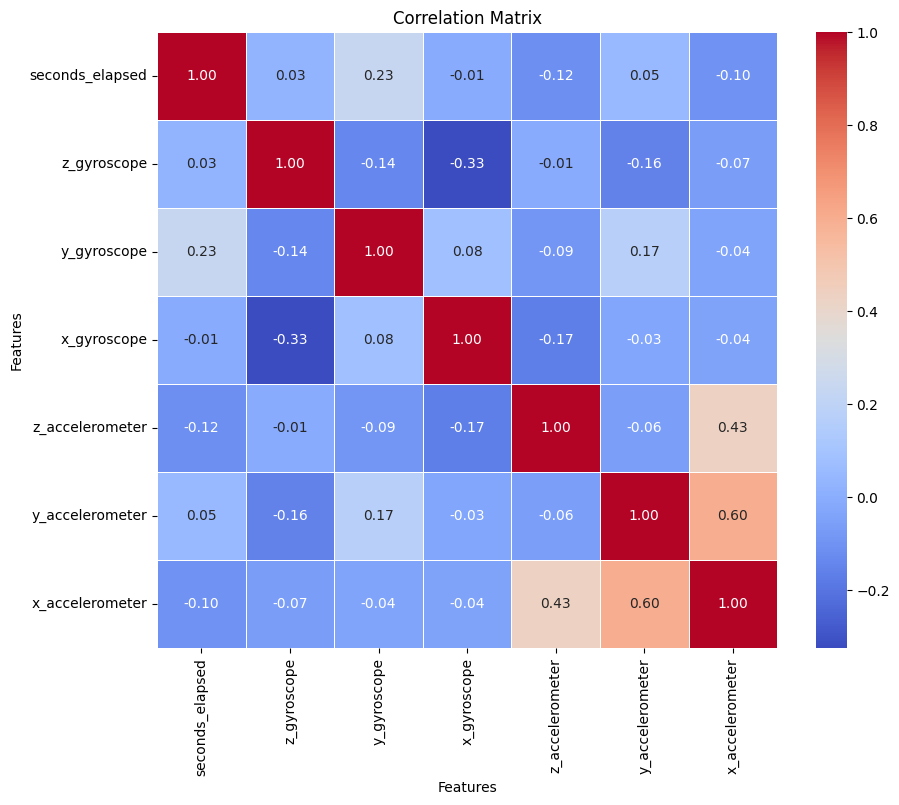

Epoch [1/1000], Loss: 1.0839
Epoch [2/1000], Loss: 1.0783
Epoch [3/1000], Loss: 1.0733
Epoch [4/1000], Loss: 1.0690
Epoch [5/1000], Loss: 1.0651
Epoch [6/1000], Loss: 1.0618
Epoch [7/1000], Loss: 1.0590
Epoch [8/1000], Loss: 1.0568
Epoch [9/1000], Loss: 1.0551
Epoch [10/1000], Loss: 1.0537
Epoch [11/1000], Loss: 1.0523
Epoch [12/1000], Loss: 1.0510
Epoch [13/1000], Loss: 1.0496
Epoch [14/1000], Loss: 1.0480
Epoch [15/1000], Loss: 1.0464
Epoch [16/1000], Loss: 1.0446
Epoch [17/1000], Loss: 1.0428
Epoch [18/1000], Loss: 1.0409
Epoch [19/1000], Loss: 1.0388
Epoch [20/1000], Loss: 1.0367
Epoch [21/1000], Loss: 1.0346
Epoch [22/1000], Loss: 1.0324
Epoch [23/1000], Loss: 1.0302
Epoch [24/1000], Loss: 1.0279
Epoch [25/1000], Loss: 1.0255
Epoch [26/1000], Loss: 1.0230
Epoch [27/1000], Loss: 1.0205
Epoch [28/1000], Loss: 1.0178
Epoch [29/1000], Loss: 1.0150
Epoch [30/1000], Loss: 1.0122
Epoch [31/1000], Loss: 1.0093
Epoch [32/1000], Loss: 1.0063
Epoch [33/1000], Loss: 1.0033
Epoch [34/1000], Lo

In [2]:
# Функція для обробки файлів
def process_file(gyroscope_file, accelerometer_file, label):
    # Зчитування та перейменування стовпців гіроскопа
    df_gyro = pd.read_csv(gyroscope_file, index_col=0)
    df_gyro = df_gyro.rename(columns={'z': 'z_gyroscope', 'y': 'y_gyroscope', 'x': 'x_gyroscope'})
    
    # Зчитування та перейменування стовпців акселерометра
    df_acc = pd.read_csv(accelerometer_file, index_col=0)
    df_acc = df_acc.rename(columns={'z': 'z_accelerometer', 'y': 'y_accelerometer', 'x': 'x_accelerometer'})
    df_acc = df_acc.drop(['seconds_elapsed'], axis=1)
    
    # Об'єднання даних гіроскопа та акселерометра
    df_combined = df_gyro.join(df_acc)
    
    # Видалення рядків з пропущеними значеннями
    df_combined.dropna(inplace=True)
    
    # Додавання мітки класу
    df_combined["Class"] = label
    
    return df_combined

# Список файлів гіроскопу та акселерометра
files = [
    ('jumprope_gyroscope.csv', 'jumprope_accelerometer.csv', 1),
    ('walk_gyroscope.csv', 'walk_accelerometer.csv', 0),
    ('run_gyroscope.csv', 'run_accelerometer.csv', 2)
]

# Обробка даних для кожного файлу
dfs = []
for gyro_file, acc_file, label in files:
    df = process_file(gyro_file, acc_file, label)
    dfs.append(df)

# Об'єднання всіх даних в один набір
dataset = pd.concat(dfs, ignore_index=True)

X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

# Поділ даних на тренувальну і валідаційну вибірки (70/30%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Нормалізація даних
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_val_normalized = scaler.transform(X_val)

# Конвертація в NumPy масиви
X_train_np = np.array(X_train_normalized)
X_val_np = np.array(X_val_normalized)
y_train_np = np.array(y_train)
y_val_np = np.array(y_val)

# Встановлення назв стовпців після нормалізації даних
X_train_normalized_df = pd.DataFrame(X_train_normalized, columns=dataset.columns[:-1])
X_val_normalized_df = pd.DataFrame(X_val_normalized, columns=dataset.columns[:-1])

# Побудова кореляційної матриці
correlation_matrix = pd.DataFrame(X_train_normalized_df).corr()

# Виведення кореляційної матриці
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

# Оголошення моделі
class DeepNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(DeepNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

input_size = 7  # Кількість ознак у вхідних даних
hidden_size1 = 128  # Розмір першого прихованого шару
hidden_size2 = 64  # Розмір другого прихованого шару
num_classes = 3  # Кількість класів

model = DeepNeuralNetwork(input_size, hidden_size1, hidden_size2, num_classes)

# Визначення функції втрат та оптимізатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Конвертація даних в тензори PyTorch
X_train_tensor = torch.FloatTensor(X_train_np)
y_train_tensor = torch.LongTensor(y_train_np)
X_val_tensor = torch.FloatTensor(X_val_np)
y_val_tensor = torch.LongTensor(y_val_np)

# Навчання моделі
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass та оптимізація
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Перевірка точності моделі на валідаційних даних
with torch.no_grad():
    outputs = model(X_val_tensor)
    _, predicted = torch.max(outputs, 1)
    accuracy = accuracy_score(y_val_tensor.numpy(), predicted.numpy())
    print(f'Accuracy on the validation set: {accuracy:.2f}')

# Обчислення матриці конфузії
cm = confusion_matrix(y_val_tensor.numpy(), predicted.numpy())
print("Confusion Matrix:")
print(cm)


Підбір гіперпараметрів відбувається через зміну епох num_epochs = х

Confusion matrix, without normalization


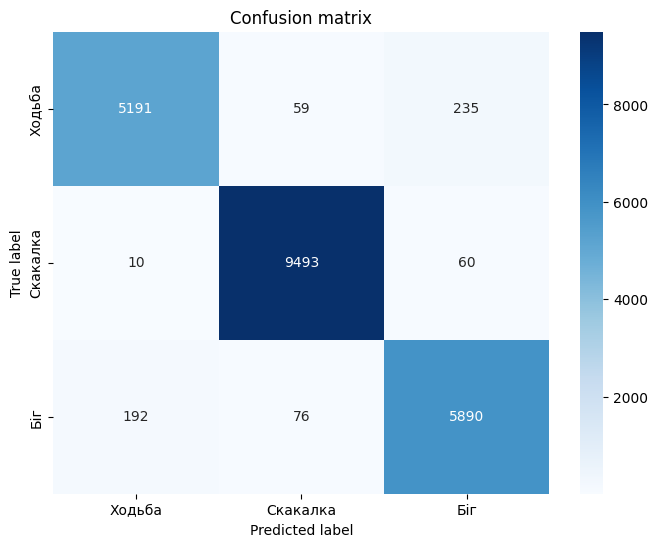

In [3]:

label_encoder = LabelEncoder()
# Обчислення матриці конфузії

class_names = ["Ходьба","Скакалка","Біг"]

# Функція для побудови матриці конфузії
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.0f', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Виклик функції для побудови графічного представлення матриці конфузії
plot_confusion_matrix(cm, class_names)
